# Exploratory Data Analysis - Electricity Demand Time Series

Objectives:
- Understand the temporal dynamics of electricity demand
- Identify seasonal patterns and weather effects
- Validate assumptions for statistical and ML models

# 1. Imports & Project Structure

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import datetime as dt, datetime
import holidays

In [2]:
# We rely on pathlib for robust and portable file paths
PROJECT_ROOT = Path.cwd().parents[0]
PROCESSED_BASE_PATH = PROJECT_ROOT / "data" / "processed"

# 2. Data Loading & Overview

In [3]:
# Parameters
country = "FR"
years = [2023, 2024]

In [4]:
# Load preprocessed data for several years
dfs = []
for year in years:
    path = (
        PROCESSED_BASE_PATH
        / f"country={country}"
        / f"year={year}"
        / "load_weather.parquet"
    )
    if path.exists():
        dfs.append(pd.read_parquet(path))

df = pd.concat(dfs, ignore_index=True).sort_values("datetime").reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   datetime                     17544 non-null  datetime64[ns, UTC]
 1   load_MW                      17544 non-null  float64            
 2   country                      17544 non-null  object             
 3   temperature_2m               17544 non-null  float32            
 4   relative_humidity_2m         17544 non-null  float32            
 5   wind_speed_10m               17544 non-null  float32            
 6   shortwave_radiation_instant  17544 non-null  float32            
 7   year                         17544 non-null  int64              
dtypes: datetime64[ns, UTC](1), float32(4), float64(1), int64(1), object(1)
memory usage: 822.5+ KB


In [6]:
# Statistical summary
df.describe()

,load_MW,temperature_2m,relative_humidity_2m,wind_speed_10m,shortwave_radiation_instant,year
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,48749.953944,12.562067,78.282188,13.297525,135.296509,2023.500684
std,9940.436742,6.723579,14.802781,6.950674,209.615128,0.500014
min,28744.000000,-5.550000,25.195589,0.000000,0.000000,2023.000000
25%,41523.500000,8.050000,69.145760,7.787991,0.000000,2023.000000
50%,47267.000000,12.050000,82.046043,12.101570,0.000000,2024.000000
75%,54983.000000,17.250000,90.137306,17.640228,209.285904,2024.000000
max,82800.000000,34.950001,100.000000,47.341022,912.246155,2024.000000


In [7]:
# Date range
df["datetime"].min(), df["datetime"].max()

(Timestamp('2023-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-12-31 23:00:00+0000', tz='UTC'))

# 3. Time Index Integrity

In [8]:
# Check if datetime is sorted
df["datetime"].is_monotonic_increasing

True

In [9]:
# Check for missing timestamps on an hourly frequency
df.set_index("datetime").asfreq("h").isna().sum()

load_MW                        0
country                        0
temperature_2m                 0
relative_humidity_2m           0
wind_speed_10m                 0
shortwave_radiation_instant    0
year                           0
dtype: int64

# 4. Global Time Series Visualization

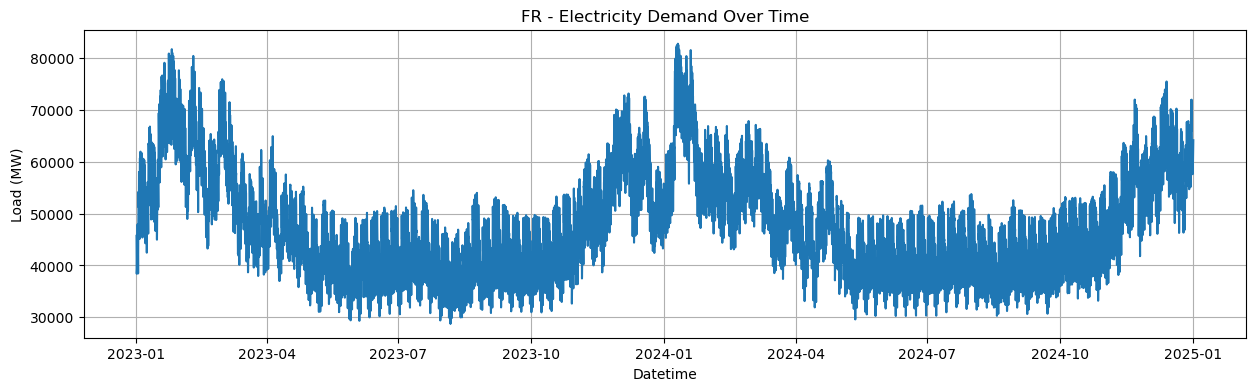

In [10]:
# First intuition of trend, volatility and seasonality
plt.figure(figsize=(15,4))
plt.plot(df["datetime"], df["load_MW"])
plt.title(f"{country} - Electricity Demand Over Time")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.grid()

Key insights:
- The time series shows a **strong annual seasonality**, with **high demand in winter** and **lower demand in summer**, mainly driven by heating needs and weather conditions.
- Clear **daily and weekly patterns** are visible, reflecting human activity cycles (night vs day, weekdays vs weekends).
- The demand exhibits **high variability**, especially during winter, with large peaks likely associated with cold spells.
- The overall shape and amplitude of the series are **consistent across years**, suggesting no major structural break between 2023 and 2024.
- The series is **non-stationary** and influenced by multiple seasonal components (hourly, weekly, yearly), which must be accounted for in modeling.

# 5. Trend & Long-Term Behavior

Rolling statistics are used for exploratory purposes to separate short-term variability from underlying demand trends.

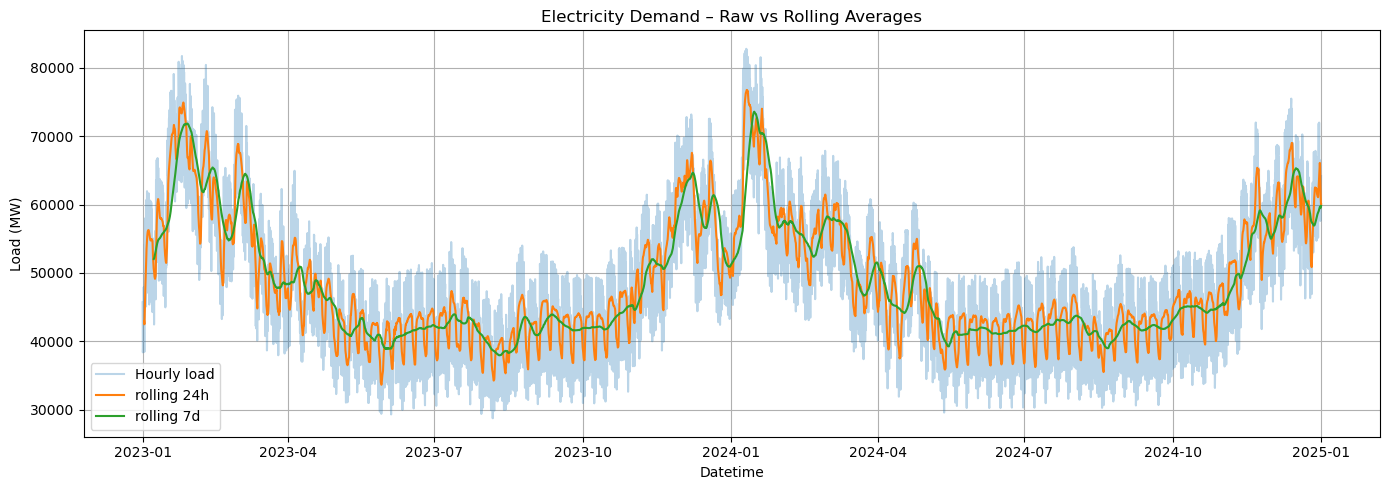

In [11]:
# Plot raw signal vs rolling means
plt.figure(figsize=(14, 5))

# Raw signal 
plt.plot(df["datetime"], df["load_MW"], alpha=0.3, label="Hourly load")

# Rolling means to smooth out noise (short-term fluctuations)
df['rolling_24h'] = df['load_MW'].rolling(window=24).mean()  
df['rolling_7d'] = df['load_MW'].rolling(window=24*7).mean()

rolling_cols = ["rolling_24h", "rolling_7d"]
# Not plotting NaN values from rolling means
for col in rolling_cols:
    mask = df[col].notna()
    plt.plot(df["datetime"][mask], df[col][mask], label=f"{col.replace('_', ' ')}")

plt.title("Electricity Demand – Raw vs Rolling Averages")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.tight_layout()
plt.grid()

plt.show()

- The hourly load series exhibits **strong short-term variability** driven by daily consumption cycles and operational effects, resulting in a highly noisy signal.
- The **24-hour rolling mean** smooths intraday fluctuations while preserving short-term dynamics, making daily demand patterns and short-lived peaks more interpretable.
- The **7-day rolling mean** reveals the underlying demand trend, clearly highlighting seasonal effects with pronounced winter peaks and summer troughs.
- The close alignment between rolling averages across years indicates **stable demand behavior** and no visible structural break between 2023 and 2024.
- Periods where the rolling means rise or fall persistently correspond to **sustained demand changes**, likely driven by temperature variations or extended behavioral effects (e.g., cold spells, holiday periods).

Key insights:
- Electricity demand is dominated by **multi-scale seasonality** (daily and annual).
- **Short-term volatility is high**, but the **long-term trend is smooth and predictable**.
- Rolling averages are effective for separating noise from structural patterns, supporting their use in exploratory analysis and feature design.
- Rolling mean changes over time and rolling variance is not constant → **non-stationary**

# 6. Seasonality Analysis

## 6.1. Hourly Seasonality (Intra-day)

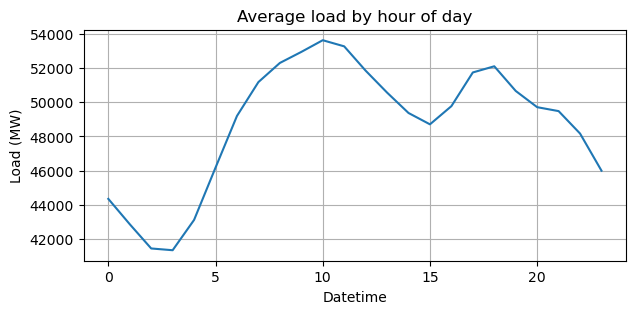

In [12]:
# Hourly profile
df["hour"] = df["datetime"].dt.hour

# Average load by hour of day
plt.figure(figsize=(7, 3))
sns.lineplot(data=df.groupby("hour")["load_MW"].mean().reset_index(), x="hour", y="load_MW")
plt.title("Average load by hour of day")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()

This plot shows a typical french daily load profile:
- Load is **lowest at night** (around 3-5 AM).
- It rises sharply in the morning, **peaking around 10-11 AM**, likely due ton increased commercial and residential activity.
- There's a **secondary peak in the evening (~6–7 PM)**, possibly linked to household consumption after work hours.
- After that, load gradually declines overnight.

## 6.2. Calendar Effects (Weekends & Holidays)

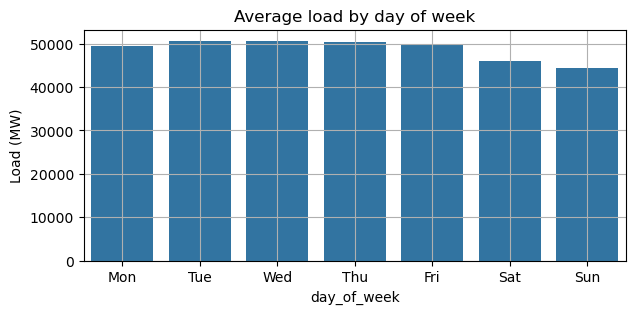

In [13]:
# Daily profile
df["day_of_week"] = df["datetime"].dt.dayofweek

# Average load by day of week
plt.figure(figsize=(7, 3))
sns.barplot(data=df.groupby("day_of_week")["load_MW"].mean().reset_index(), x="day_of_week", y="load_MW")
plt.title("Average load by day of week")
plt.ylabel("Load (MW)")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.grid(True)
plt.show()

This plot shows that the load is higher on weekdays than at weekends.

In [16]:
# Add holidays feature
fr_holidays = holidays.FR()
df['is_holiday'] = df['datetime'].apply(lambda x: 1 if x.date() in fr_holidays else 0)

## 6.3. Monthly / Yearly Seasonality

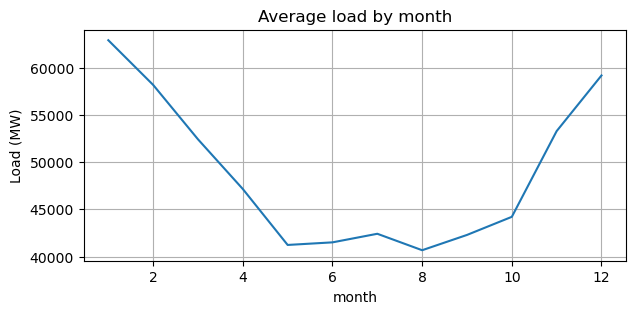

In [18]:
# Monthly profile
df["month"] = df["datetime"].dt.month

# Average load by month
plt.figure(figsize=(7, 3))
sns.lineplot(data=df.groupby("month")["load_MW"].mean().reset_index(), x="month", y="load_MW")
plt.title("Average load by month")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()

This plot shows that the load is highest in winter (December-February) and lowest in summer (May-September), with a minimum peak in August.

# 7. Weather Impact Analysis

## 7.1. Load vs Weather features

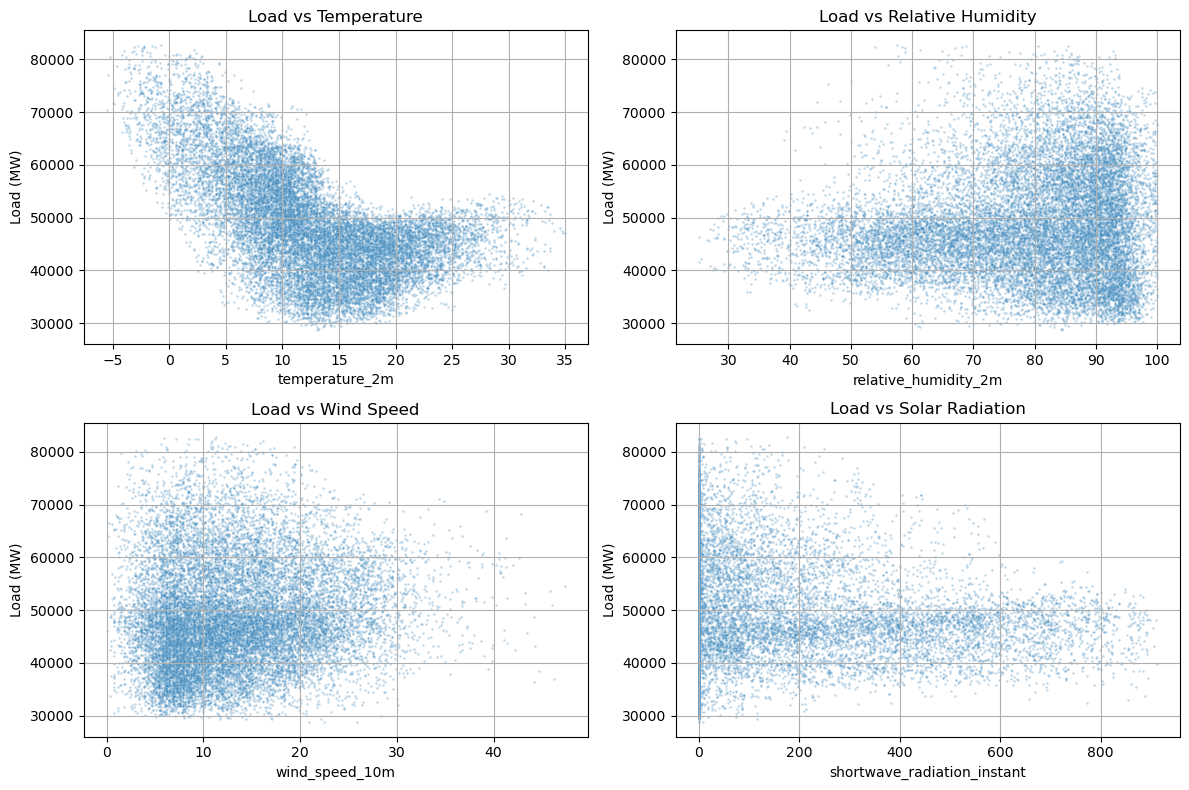

In [19]:
# Scatter plots of weather features vs load
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(data=df, x='temperature_2m', y='load_MW', alpha=0.3, s=3, ax=axs[0, 0])
axs[0, 0].set_title(f"Load vs Temperature")

sns.scatterplot(data=df, x='relative_humidity_2m', y='load_MW', alpha=0.3, s=3, ax=axs[0, 1])
axs[0, 1].set_title(f"Load vs Relative Humidity")

sns.scatterplot(data=df, x='wind_speed_10m', y='load_MW', alpha=0.3, s=3, ax=axs[1, 0])
axs[1, 0].set_title(f"Load vs Wind Speed")

sns.scatterplot(data=df, x='shortwave_radiation_instant', y='load_MW', alpha=0.3, s=3, ax=axs[1, 1])
axs[1, 1].set_title(f"Load vs Solar Radiation")

for ax in axs.flat:
    ax.set_ylabel("Load (MW)")
    ax.grid(True)

plt.tight_layout()
plt.show()

Interpretation of the plots:

- **Temperature vs Load**: There’s a clear inverse relationship below 15°C, as temperature increases, load generally decreases, likely due to reduced heating demand. However, above approximately 15°C, load starts increasing again, probably due to increased air conditioning use during higher temperatures.
- **Relative humidity vs Load**: Weak or no strong correlation, the relationship appears diffuse.
- **Wind Speed vs Load**: Weak or no strong correlation, the relationship appears diffuse.
- **Solar Radiation vs Load**: Weak or no strong correlation, the relationship appears diffuse.

## 7.2. Correlation Analysis

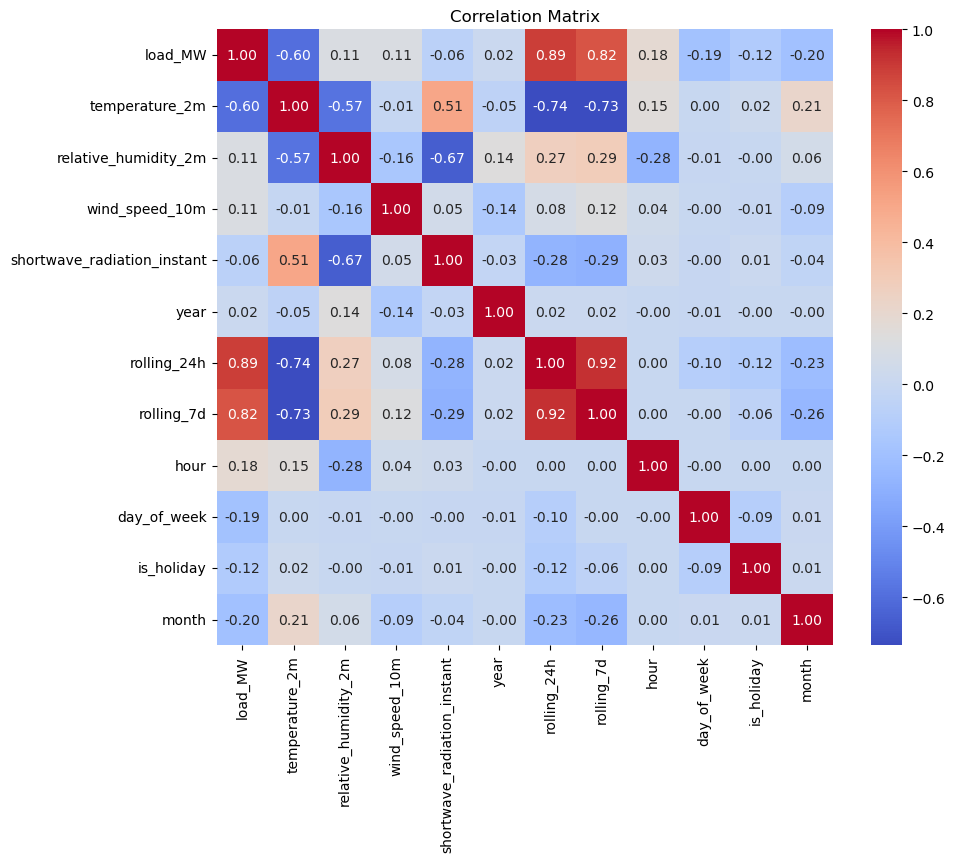

In [20]:
# Keep only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

**Load (load_MW)** is:

* **Strongly positively correlated with its rolling averages**:

  * 24h rolling mean: **0.89**
  * 7d rolling mean: **0.82**
    → This is expected and confirms a **strong temporal inertia** of demand: past consumption is a very good predictor of current load.

* **Strongly negatively correlated with temperature (-0.60)**:
  → Lower temperatures are associated with higher electricity demand, most likely due to **heating usage**.

* **Moderately positively correlated with hour (0.18)**:
  → This reflects **intra-day usage patterns** (day vs night activity).

* **Moderately negatively correlated with calendar variables**:

  * day_of_week: **-0.19**
  * month: **-0.20**
    → This shows **weekly and seasonal structure** in demand, but weaker than weather and rolling features.

* **Very weakly correlated with other weather variables**:

  * humidity: **0.11**
  * wind speed: **0.11**
  * solar radiation: **-0.06**
    → These variables likely have **secondary or indirect effects** compared to temperature.

**Temperature (temperature_2m)** has:

* A **strong positive correlation with solar radiation (0.51)**:
  → Warmer days are generally sunnier.

* A **strong negative correlation with relative humidity (-0.57)**:
  → Typical meteorological behavior: warm air tends to be drier.

* A **strong negative correlation with load (-0.60)** and with rolling load features:

  * rolling_24h: **-0.74**
  * rolling_7d: **-0.73**
    → Confirms that **temperature is the most influential weather driver** of electricity demand.

* A **moderate positive correlation with month (0.21)**:
  → Captures **seasonality** (summer vs winter).

**Relative humidity (relative_humidity_2m)** is:

  * Strongly **negatively correlated with solar radiation (-0.67)**
  * Moderately **positively correlated with rolling load features (~0.28–0.29)**
    → This mostly reflects **weather regime and seasonal structure**, not a direct causal impact on load.

**Solar radiation (solar_radiation_instant)** is:

  * Negatively correlated with load (-0.06) and rolling features (~ -0.28 / -0.29)
    → Likely a **proxy for seasonality** (winter vs summer) rather than a direct driver.

**Wind speed (wind_speed_10m):**

* Wind speed shows **almost no correlation with load (0.11)** and with other variables.
  → It probably has **little direct explanatory power** for demand in this dataset.

**Time features:**

* **Rolling_24h and Rolling_7d are extremely correlated (0.92)**:
  → They contain **very similar information** (short-term vs slightly longer-term memory).

* **Year has almost zero correlation with everything**:
  → No strong long-term linear trend in the data.

* **Hour, day_of_week, month**:

  * Hour has a small correlation with load (0.18) → **daily cycle**
  * Day_of_week and month have modest correlations (~ -0.2) → **weekly and seasonal effects**
  * is_holiday has a small correlation with load (0.12)

**Overall conclusions:**

* **The most important drivers of load are**:

  1. **Past load values (rolling features)** → strong temporal dependence
  2. **Temperature** → main exogenous weather driver
  3. **Calendar effects** (hour, month, day_of_week) → structure and seasonality

* **Other weather variables (humidity, wind, solar)** mostly act as **indirect seasonal indicators** rather than strong direct predictors.

* **Feature redundancy**:

  * rolling_24h and rolling_7d are highly collinear → you might keep both for ML models, but they carry very similar information.
  * Month and temperature partially encode the same seasonal signal.

# 8. Stationarity Analysis (for Time Series)

In time series modeling, **stationarity** is a key assumption for many classical statistical models (e.g. ARIMA/SARIMA, ETS, linear regression with lagged features).

A time series is **stationnary** if:
- Its **mean** is constant over time
- Its **variance** is constant over time
- Its **autocovariance structure** does not depend on time

We saw earlier in the notebook that electricity demand time serie is **non-stationary** due to:
- Long-term trends
- Strong seasonal patterns (daily, weekly, yearly)
- External drivers such and temperature and calendar effects (weekdays and weekends/holidays)

## 8.1. Statistical Stationarity Test: Augmented Dickey-Fuller (ADF) Test

The ADF test checks for the presence of a unit root.
- Null hypothesis (H₀): The time series has a unit root → non-stationary
- Alternative hypothesis (H₁): The time series is stationary

Decision rule:
- If p-value < 0.05, reject H₀ → stationary
- If p-value ≥ 0.05, fail to reject H₀ → non-stationary

In [21]:
# ADF test for stationarity
adf_result = adfuller(df["load_MW"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -5.1927974249013324
p-value: 9.094700839431985e-06
Critical Values:
   1%: -3.430723750472268
   5%: -2.8617051832726124
   10%: -2.5668579227683557


Key Observations:

- The Augmented Dickey-Fuller test strongly rejects the null hypothesis of a unit root (p-value < 0.001), suggesting that **the series is stationary in the ADF sense**.

- However, visual inspection and seasonal analysis clearly show strong daily and weekly seasonal patterns. This highlights a known **limitation of the ADF test**: it detects unit-root non-stationarity but does not account for deterministic seasonality.

- As a result, despite passing the ADF test, the electricity demand series still **requires seasonal modeling or seasonal differencing**.

## 8.2. Autocorrelation Analysis (ACF & PACF)

Autocorrelation analysis helps us understand:
- How past values influence the current demand
- The memory of the time series
- Appropriate lag orders for AR / MA components
- Seasonal patterns (daily, weekly)

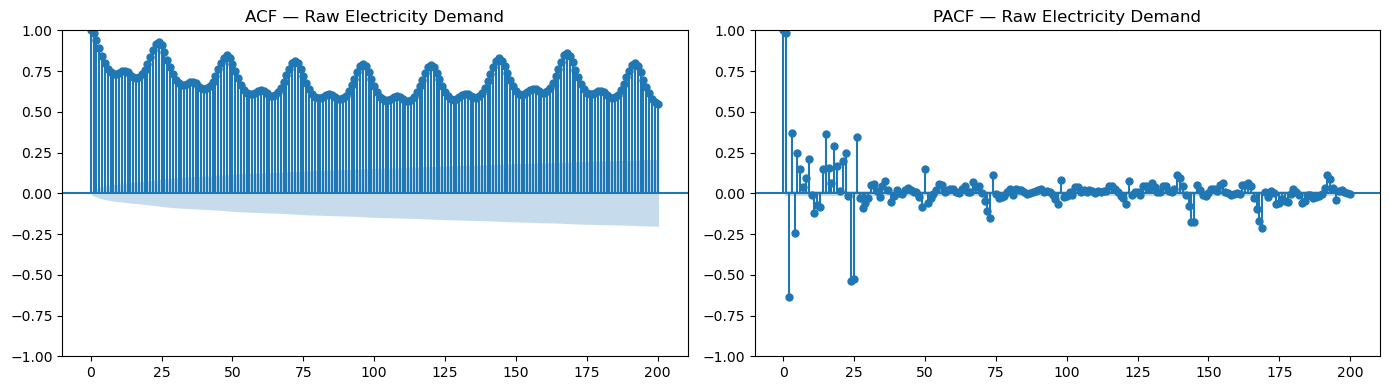

In [23]:
# ACF & PACF of the raw series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["load_MW"], lags=200, ax=axes[0])
plot_pacf(df["load_MW"], lags=200, ax=axes[1], method="ywm")

axes[0].set_title("ACF — Raw Electricity Demand")
axes[1].set_title("PACF — Raw Electricity Demand")

plt.tight_layout()
plt.show()

Key insights:
- Very slow decay in ACF → non-stationarity
- Strongs spikes at: lag 24 (daily), and every 24-hours (lag 28, 168 (weekly), etc)
- PACF with multiple significant lags

This confirms strong seasonality, long memory and that raw series are not suitable for ARIMA/SARIMA directly.

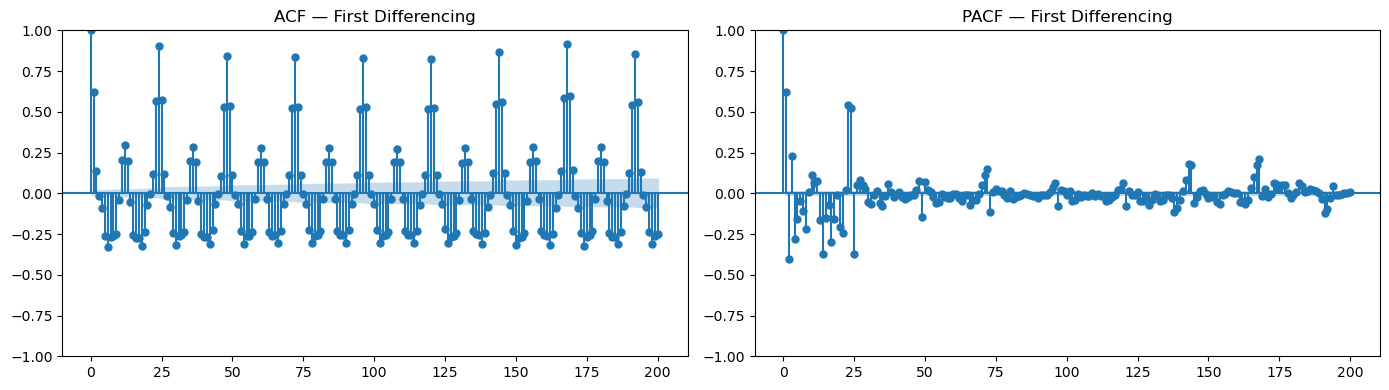

In [ ]:
# ACF & PACF for the first differenced (1h) series
df["load_diff_1"] = df["load_MW"].diff()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["load_diff_1"].dropna(), lags=200, ax=axes[0])
plot_pacf(df["load_diff_1"].dropna(), lags=200, ax=axes[1], method="ywm")

axes[0].set_title("ACF — First Differencing")
axes[1].set_title("PACF — First Differencing")

plt.tight_layout()
plt.show()

Key insights:
- Trend largely removed
- Daily seasonality still present (lag 24)

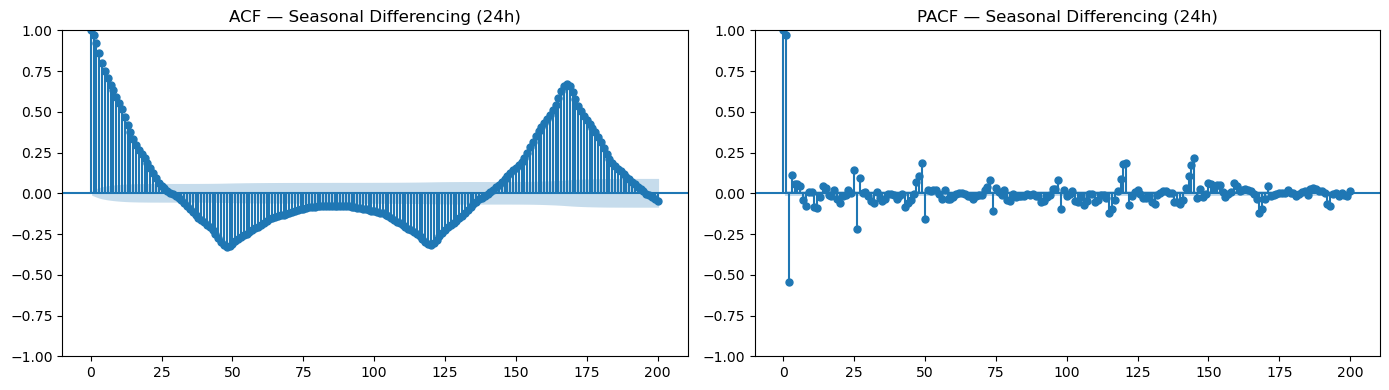

In [25]:
# ACF & PACF for the seasonal differenced (24h) series
df["load_diff_24"] = df["load_MW"].diff(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["load_diff_24"].dropna(), lags=200, ax=axes[0])
plot_pacf(df["load_diff_24"].dropna(), lags=200, ax=axes[1], method="ywm")

axes[0].set_title("ACF — Seasonal Differencing (24h)")
axes[1].set_title("PACF — Seasonal Differencing (24h)")

plt.tight_layout()
plt.show()

Key insights:
- Daily seasonality reduced (almost zero)
- Weekly seasonality (168h) remains

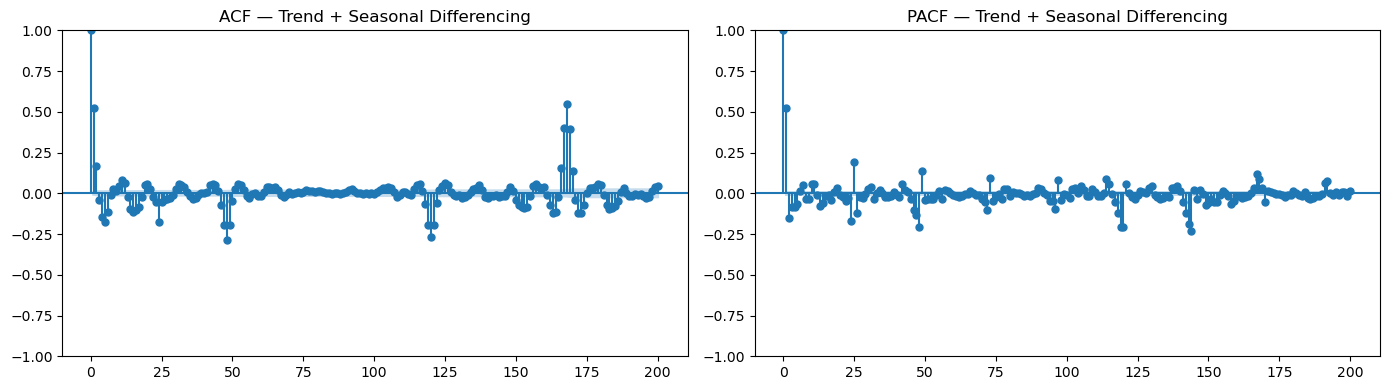

In [26]:
# ACF & PACF for the trend + seasonal differenced (1h + 24h) series
df["load_diff_1_24"] = df["load_MW"].diff().diff(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["load_diff_1_24"].dropna(), lags=200, ax=axes[0])
plot_pacf(df["load_diff_1_24"].dropna(), lags=200, ax=axes[1], method="ywm")

axes[0].set_title("ACF — Trend + Seasonal Differencing")
axes[1].set_title("PACF — Trend + Seasonal Differencing")

plt.tight_layout()
plt.show()

Key insights:
- ACF decays quickly
- Only a few significant lags remain (48h, 120h, 168h)
- Suitable for SARIMA modeling

ACF / PACF suggest:
- Lag features: 1h, 24h, 168h
- Rolling means: 24h, 7d
- Calendar features remain crucial

Autocorrelation analysis reveals **strong daily and weekly dependencies** in electricity demand. After trend and seasonal differencing, the series exhibits short memory, making it suitable for SARIMA modeling and informing **lag-based feature engineering for ML models**.

# 10. Conclusion and Next Steps

This exploratory data analysis highlights that electricity demand is driven by **strong temporal dependencies and multi-scale seasonality**, with clear **daily, weekly, and annual patterns**. Demand is highest in winter and lowest in summer, with stable behavior across years and no visible structural break, suggesting a relatively predictable long-term process.

The series is **non-stationary**, highly volatile at the hourly level, but exhibits a **smooth and stable underlying trend** when viewed through rolling averages. This confirms the importance of accounting for both **short-term dynamics** and **long-term seasonal structure** in any forecasting model.

Among exogenous variables, **temperature emerges as the dominant weather driver**, showing a strong negative relationship with electricity demand, consistent with heating usage in colder periods. Other meteorological variables (humidity, wind speed, solar radiation) appear to have **secondary or indirect effects**, mainly acting as proxies for broader seasonal regimes. **Calendar effects** (hour of day, day of week, month, holidays) capture important behavioral patterns but are weaker than temperature and lag-based features.

Overall, the key takeaways for modeling are:
- Electricity demand has **strong temporal inertia**, making past load values and rolling statistics critical predictors.
- **Temperature** should be treated as the primary exogenous variable.
- The presence of **multiple seasonalities** requires explicit handling through feature engineering or seasonal models.
- Some features are highly correlated (e.g., rolling 24h vs 7d), which should be considered when designing models.

Next steps will focus on feature engineering, including lagged load features, rolling statistics, calendar variables, and temperature transformations, followed by the development of baseline statistical models (e.g., SARIMA), machine learning and deep learning models to benchmark predictive performance.